Ładowanie i przetwarzanie obrazów odcisków palców

In [5]:
# import cv2
# import os

# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)
#     return images

# def preprocess_image(image):
#     normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#     return normalized_image



Liczba wczytanych zdjęć: 320
Ścieżka do losowego obrazu: fingerprints/DB3_B\105_8.tif


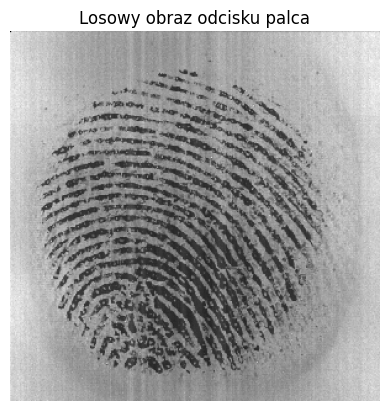

In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

def load_tiff_images_from_folder(base_folder):
    images = []
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith(".tif"):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append((img_path, img))
    return images

folder_path = 'fingerprints/'  
images = load_tiff_images_from_folder(folder_path)

# Informacje o liczbie wczytanych zdjęć
print(f"Liczba wczytanych zdjęć: {len(images)}")

# Wyświetlenie losowego obrazu z wczytanych
if images:
    random_image_path, random_image = random.choice(images)
    print(f"Ścieżka do losowego obrazu: {random_image_path}")
    plt.imshow(random_image, cmap='gray')
    plt.title("Losowy obraz odcisku palca")
    plt.axis('off')  # Wyłączenie osi
    plt.show()
else:
    print("Nie wczytano żadnych obrazów.")


Ekstrakcja minucji

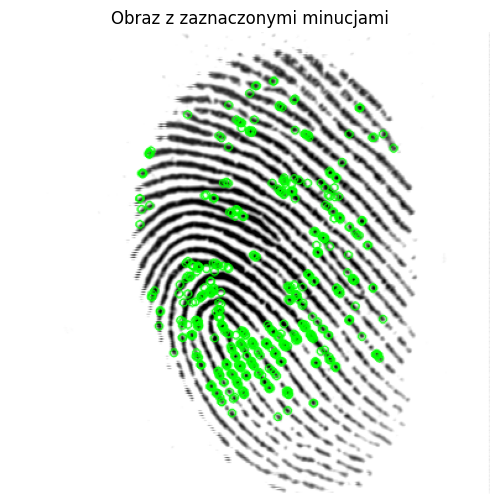

Liczba wykrytych kluczowych punktów (minucji): 500


In [2]:
# def extract_minutiae(image):
#     orb = cv2.ORB_create()
#     keypoints = orb.detect(image, None)
#     keypoints, descriptors = orb.compute(image, keypoints)
#     return keypoints

def preprocess_image(image):
    # Normalizacja obrazu do zakresu 0-255 i konwersja do uint8
    processed_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return processed_image

def extract_minutiae(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def show_image_with_keypoints(image, keypoints):
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title("Obraz z zaznaczonymi minucjami")
    plt.axis('off')
    plt.show()



# Załóżmy, że 'random_image' to wczytany losowy obraz odcisku palca
random_image = images[0][1]  # Przykład, dostosuj indeks do faktycznego obrazu

# Przetwarzanie wstępne
processed_image = preprocess_image(random_image)

# Ekstrakcja minucji
keypoints, descriptors = extract_minutiae(processed_image)

# Wyświetlenie obrazu z minucjami
show_image_with_keypoints(processed_image, keypoints)

# Opcjonalnie, wypisz liczby kluczowych punktów
print(f"Liczba wykrytych kluczowych punktów (minucji): {len(keypoints)}")



Analiza geometrii palca

Zmierzone wymiary: {'x': 0, 'y': 0, 'width': 388, 'height': 374}


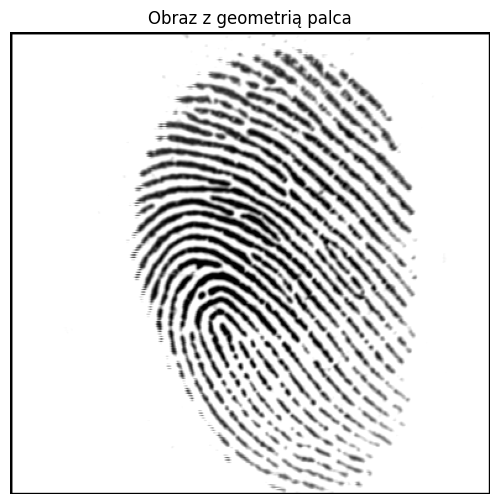

In [3]:
def measure_finger_geometry(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        return {"x": x, "y": y, "width": w, "height": h}  # Dodajemy 'x' i 'y' do zwracanego słownika
    return None


def show_image_with_geometry(image, geometry):
    if geometry:
        x, y, w, h = geometry["x"], geometry["y"], geometry["width"], geometry["height"]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = f"Width: {w}, Height: {h}"
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    else:
        plt.text(0.5, 0.5, 'No contours found', horizontalalignment='center', verticalalignment='center')
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.title("Obraz z geometrią palca")
    plt.axis('off')
    plt.show()


# Przetwarzanie wstępne obrazu już wykonano w poprzednim kroku, użyjemy tego samego obrazu 'processed_image'

# Mierzenie geometrii
geometry = measure_finger_geometry(processed_image)
print(f"Zmierzone wymiary: {geometry if geometry else 'Brak konturów'}")

# Wyświetlanie obrazu z geometrią
if geometry:
    show_image_with_geometry(processed_image, geometry)
else:
    print("Nie znaleziono konturów do wyświetlenia.")


In [4]:
def validate_geometry_consistency(image, iterations=5):
    results = []
    for _ in range(iterations):
        processed_image = preprocess_image(image)
        geometry = measure_finger_geometry(processed_image)
        results.append(geometry)
        if all(r == results[0] for r in results):
            print("Geometry measurements are consistent.")
        else:
            print("Geometry measurements vary:", results)

# Wywołaj funkcję walidacji na losowym obrazie
validate_geometry_consistency(random_image)


Geometry measurements are consistent.
Geometry measurements are consistent.
Geometry measurements are consistent.
Geometry measurements are consistent.
Geometry measurements are consistent.


Przygotowanie danych do sieci

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

def load_image_paths(base_folder):
    image_paths = []
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.lower().endswith(".tif"):
                image_paths.append(os.path.join(root, file))
    return image_paths

base_folder = 'fingerprints'
image_paths = load_image_paths(base_folder)

# Podziel dane na zbiory treningowe i testowe/validacyjne
train_paths, test_paths = train_test_split(image_paths, test_size=0.3, random_state=42)

# Podziel zbiór testowy na testowy i walidacyjny
test_paths, val_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

def create_and_move_files(file_paths, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for path in file_paths:
        file_name = os.path.basename(path)
        shutil.move(path, os.path.join(destination_folder, file_name))

# Stwórz foldery i przenieś pliki
create_and_move_files(train_paths, 'data/train')
create_and_move_files(test_paths, 'data/test')
create_and_move_files(val_paths, 'data/val')


In [ ]:
# def extract_features_for_all_images(image_paths):
#     data = []
#     for image_path in image_paths:
#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         if image is not None:
#             processed_image = preprocess_image(image)
#             keypoints, descriptors = extract_minutiae(processed_image)
#             geometry = measure_finger_geometry(processed_image)
#             data.append((image_path, keypoints, descriptors, geometry))
#     return data

# # Załadowanie ścieżek obrazów z wszystkich folderów
# all_image_paths = load_image_paths('data/train') + load_image_paths('data/test') + load_image_paths('data/val')
# all_features = extract_features_for_all_images(all_image_paths)


In [ ]:
# import csv

# def save_features_to_csv(features, filename):
#     with open(filename, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(["Path", "Keypoints", "Descriptors", "Geometry"])
#         for feature in features:
#             path, keypoints, descriptors, geometry = feature
#             # Zapisz tylko niezbędne informacje, np. liczba kluczowych punktów i dane geometryczne
#             keypoints_count = len(keypoints)
#             geometry_data = (geometry['x'], geometry['y'], geometry['width'], geometry['height']) if geometry else (None, None, None, None)
#             writer.writerow([path, keypoints_count, descriptors, geometry_data])

# # Zapisz cechy do pliku CSV
# save_features_to_csv(all_features, 'fingerprint_features.csv')


In [10]:
import os

def verify_paths(base_folder):
    if not os.path.exists(base_folder):
        print(f"Folder {base_folder} nie istnieje.")
        return False

    train_folder = os.path.join(base_folder, 'train')
    test_folder = os.path.join(base_folder, 'test')
    val_folder = os.path.join(base_folder, 'val')

    for folder in [train_folder, test_folder, val_folder]:
        if not os.path.exists(folder):
            print(f"Folder {folder} nie istnieje.")
            return False
        if not os.listdir(folder):
            print(f"Folder {folder} jest pusty.")
            return False

    print("Wszystkie ścieżki są poprawne i foldery zawierają pliki.")
    return True

# Sprawdź ścieżki
base_folder = 'data'
verify_paths(base_folder)


Wszystkie ścieżki są poprawne i foldery zawierają pliki.


True

Budowanie sieci

In [6]:
import cv2
import numpy as np

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (96, 96))  # Dostosuj rozmiar do potrzeb modelu
    image = image.astype('float32') / 255.0  # Normalizacja
    return image

def extract_minutiae_features(image):
    orb = cv2.ORB_create(nfeatures=500)  # Można dostosować liczbę cech
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def measure_finger_geometry(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        return {"x": x, "y": y, "width": w, "height": h}
    return None


In [11]:
train_paths = load_image_paths(os.path.join(base_folder, 'train'))
test_paths = load_image_paths(os.path.join(base_folder, 'test'))
val_paths = load_image_paths(os.path.join(base_folder, 'val'))


In [12]:
def prepare_dataset(image_paths):
    data = []
    for image_path in image_paths:
        try:
            image = preprocess_image(image_path)
            keypoints, descriptors = extract_minutiae_features(image)
            geometry = measure_finger_geometry(image)
            data.append((image, keypoints, descriptors, geometry))
        except Exception as e:
            print(f"Błąd przetwarzania obrazu {image_path}: {e}")
    return data

train_data = prepare_dataset(train_paths)
test_data = prepare_dataset(test_paths)
val_data = prepare_dataset(val_paths)


Błąd przetwarzania obrazu data\train\101_1.tif: OpenCV(4.9.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

Błąd przetwarzania obrazu data\train\101_2.tif: OpenCV(4.9.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_O

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, concatenate

# Tworzenie modelu bazowego dla obrazów
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

# Architektura główna
def create_main_model(input_shape, num_geometry_features):
    image_input = Input(shape=input_shape)
    geometry_input = Input(shape=(num_geometry_features,))
    
    base_network = create_base_network(input_shape)
    image_features = base_network(image_input)
    
    combined_features = concatenate([image_features, geometry_input])
    classification = Dense(1, activation='sigmoid')(combined_features)
    
    model = Model(inputs=[image_input, geometry_input], outputs=classification)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Drugie podejście